# Predicting Loan Default Risk: Multiclass Classification with getML

This notebook demonstrates how to use one of [getML](https://getml.com)'s advanced relational learning algorithm, FastProp, to predict customer loan defaults in a Czech banking context. Our analysis leverages comprehensive data including customer profiles, transaction histories, and historical loan outcomes.

We use the [financial dataset](https://relational.fit.cvut.cz/dataset/Financial), where the target has multiple classes, from [CTU Relational Learning Repository](https://relational.fel.cvut.cz/).

<br>

**Why use getML FastProp?:**
- **Relational Learning.** FastProp (short for Fast Propositionalization) extracts features from related tables without manual SQL or deep business domain expertise.  
- **Blazing Fast.** FastProp runs [60 to 1000 times faster](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than alternatives like [featuretools](https://www.featuretools.com) or [tsfresh](https://tsfresh.com), scaling easily to millions of rows.
- **Superior Performance.** FastProp frequently outperforms graph neural networks and models with handcrafted features on relational learning tasks.  

<br>

### Dataset Description
>
> The *financial* dataset, also known as the PKDD'99 Financial dataset, is a comprehensive relational dataset used primarily for multiclass classification tasks. The dataset consists of information related to loan applications, including successful and unsuccessful loans, along with associated transactions.
> 
> **Data Model:**
> - The dataset is structured into multiple tables: `loan`, `order`, `trans`, `disp`, `account`, `client`, `card`, and `district`.
> - Each table contains various attributes, such as `loan_id`, `account_id`, `amount`, `date`, `status`, etc.
> 
> **Task and Target Column:**
> - The primary task is *multiclass classification*, aiming to predict the loan outcome.
> - The target column is `status` in the `loan` table, which indicates the outcome of the loan (e.g., successful or not).
> 
> **Column Types:**
> - The dataset includes a mix of data types:
>   - *Integer* (e.g., `loan_id`, `account_id`)
>   - *Varchar* (e.g., `status`, `type`)
>   - *Date* (e.g., `date`, `birth_date`)
>   - *Decimal* (e.g., `payments`, `amount`)
> 
> **Metadata:**
> - Size: 78.8 MB
> - Number of tables: 8
> - Total number of rows: 1,090,086
> - Total number of columns: 55
> - Missing values: Yes
> - Target table: `loan`
> - Target ID: `account_id`
> - Target timestamp: `date`
> 
> **Research and Usage:**
> - The dataset has been widely used in research for developing and testing classification algorithms.
> - It has been referenced in various studies, such as "Constrained Sequential Pattern Knowledge in Multi-Relational Learning" and "Wordification: Propositionalization by unfolding relational data into bags of words."
> - Algorithms like Aleph, CoTReC, and CrossMine have been applied to this dataset, achieving varying levels of accuracy.
> 
> This dataset is a valuable resource for exploring financial data analysis, particularly in predicting loan outcomes based on historical transaction data.

### Tables
Population table: loan

<h4>
  <details open>
     <summary>ER Diagram</summary>
       <img src="https://relational.fel.cvut.cz/assets/img/datasets-generated/financial.svg" alt="financial ER Diagram">
   </details>
</h4>

## 1. Setup

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> We have prepared an [environment with all necessary dependencies](pyproject.toml) for you. To to use it, just start jupyter lab through `uv run jupyter lab` from the repository root.

In this step, we:
- Import necessary libraries
- Set a getML project

In [1]:
import getml
import pandas as pd
from IPython.display import display, HTML

from ctu.utils.data import load_ctu_dataset
from ctu.utils.metrics import prob_to_acc

# Enable textual output to avoid rendering issues in certain JupyterLab environments
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True
getml.utilities.progress.FORCE_MONOCHROME_OUTPUT = True

# Set the project name in getML for tracking and managing objects
getml.set_project("financial")

  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01


Connected to project 'financial'.

---
## 2. Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)


### Objectives:
- Download the data
- Inspect columns to understand the schema
- Do the necessary preprocessing
- Assign appropriate roles (join_key, time_stamp, numerical, categorical, etc.)




To load the dataset, we use the `load_ctu_dataset` function from the `utils`
module. This function returns a tuple with the population table as the first
element and the a dictionary of peripheral tables as the second element.

In [2]:
loan, peripheral = load_ctu_dataset("financial")

(
    account,
    card,
    client,
    disp,
    district,
    order,
    trans,
) = peripheral.values()

Analyzing schema:   0%|          | 0/8 [00:00<?, ?it/s]

Building data:   0%|          | 0/8 [00:00<?, ?it/s]

Now, we can inspect all tables and annotate the columns with [roles](https://getml.com/latest/user_guide/concepts/annotating_data/).

### a. Loan & Account Tables

In [3]:
# Inspect the structure of the loan table
loan

name,status,loan_id,account_id,date,amount,duration,payments,split
role,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,4959,2,1994-01-05,80952,24,3373,val
1,1,4961,19,1996-04-29,30276,12,2523,train
2,0,4962,25,1997-12-08,30276,12,2523,train
3,2,4967,37,1998-10-14,318480,60,5308,train
4,3,4968,38,1998-04-19,110736,48,2307,train
,...,...,...,...,...,...,...,...
677,3,7294,11327,1998-09-27,39168,24,1632,train
678,3,7295,11328,1998-07-18,280440,60,4674,val
679,3,7304,11349,1995-10-29,419880,60,6998,train


In [4]:
# Inspect the structure of the account table
account

name,account_id,district_id,frequency,date
role,unused_string,unused_string,unused_string,unused_string
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26
2,3,5,POPLATEK MESICNE,1997-07-07
3,4,12,POPLATEK MESICNE,1996-02-21
4,5,15,POPLATEK MESICNE,1997-05-30
,...,...,...,...
4495,11333,8,POPLATEK MESICNE,1994-05-26
4496,11349,1,POPLATEK TYDNE,1995-05-26
4497,11359,61,POPLATEK MESICNE,1994-10-01


#### Need for join
The `date` column in the `loan` table is the date when a loan was granted. To be fair, we should only use the data (e.g. transactions) prior to this date to assess the default risk. We want to avoid data leakage. 

Since getML offers setting this constraint between the tables linked directly, we can merge `loan` and `account` tables together into a `population` table, join the `population` table with `trans` and limit the transactions to only those which have taken place before a loan was granted.

Here, we join the `loan` and `account` tables. The join between `population` and `trans` tables and the limit on transactions will take place when defining the data model later. 

In [5]:
loan_pd = loan.to_pandas()

account_pd = account.to_pandas()

population_pd = loan_pd.merge(account_pd, on='account_id', how='left', suffixes=('_loan', '_account'))
population_pd

,status,loan_id,account_id,date_loan,amount,duration,payments,split,district_id,frequency,date_account
0,0,4959,2,1994-01-05,80952,24,3373,val,1,POPLATEK MESICNE,1993-02-26
1,1,4961,19,1996-04-29,30276,12,2523,train,21,POPLATEK MESICNE,1995-04-07
2,0,4962,25,1997-12-08,30276,12,2523,train,68,POPLATEK MESICNE,1996-07-28
3,2,4967,37,1998-10-14,318480,60,5308,train,20,POPLATEK MESICNE,1997-08-18
4,3,4968,38,1998-04-19,110736,48,2307,train,19,POPLATEK TYDNE,1997-08-08
...,...,...,...,...,...,...,...,...,...,...,...
677,3,7294,11327,1998-09-27,39168,24,1632,train,7,POPLATEK MESICNE,1997-10-15
678,3,7295,11328,1998-07-18,280440,60,4674,val,54,POPLATEK MESICNE,1996-11-05
679,3,7304,11349,1995-10-29,419880,60,6998,train,1,POPLATEK TYDNE,1995-05-26
680,0,7305,11359,1996-08-06,54024,12,4502,train,61,POPLATEK MESICNE,1994-10-01


#### Multiclass classification with getML

The target column (`status`) has four classes as described in the [original source](https://web.archive.org/web/20170808112955/http://lisp.vse.cz/pkdd99/Challenge/) of the data: 
- 0 - contract finished, no problems (A)
- 1 - contract finished, loan not payed (B)
- 2 - running contract, OK so far (C)
- 3 - running contract, client in debt (D)

getML deals with multiclass classification by dissecting it into multiple binary classification problems. Our `make_target_columns` function takes the dataframe containing a target column with multiple classes and returns a [View](https://getml.com/latest/reference/data/view/) with more than one target columns: one target column for each class. 

Except FastProp, feature learners create features for each class target individually. However, all the class targets can be fitted and predicted with a single pipeline. 

In [6]:
population_gd = getml.data.DataFrame.from_pandas(population_pd, name='population_gd')

population_targets = ( 
    getml.data.make_target_columns(population_gd, "status")
    .with_column(population_gd.status, name="status")) 

# `make_target_columns` returns only the binary target columns (status=*). With `with_column` we 
# add the original multiclass target column (status) back.

population_targets

name,status=0,status=1,status=2,status=3,loan_id,account_id,date_loan,amount,duration,payments,split,district_id,frequency,date_account,status
role,target,target,target,target,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,0,0,0,4959,2,1994-01-05,80952,24,3373,val,1,POPLATEK MESICNE,1993-02-26,0
1,0,1,0,0,4961,19,1996-04-29,30276,12,2523,train,21,POPLATEK MESICNE,1995-04-07,1
2,1,0,0,0,4962,25,1997-12-08,30276,12,2523,train,68,POPLATEK MESICNE,1996-07-28,0
3,0,0,1,0,4967,37,1998-10-14,318480,60,5308,train,20,POPLATEK MESICNE,1997-08-18,2
4,0,0,0,1,4968,38,1998-04-19,110736,48,2307,train,19,POPLATEK TYDNE,1997-08-08,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Setting the roles
[`Roles`](https://getml.com/latest/user_guide/concepts/annotating_data/#annotating-data-roles) allow getML to:
- Efficiently encode links between tables (`join_key`)
- Interpret timestamps for time-aware modeling (`time_stamp`)
- Encode numerical, categorical, and text features (`numerical`, `categorical`, `text`)
- Ignore irrelevant columns (`unused_float` or `unused_string`)

In [7]:
# Role assignment breakdown on `population`:
# - `status=*`: Target columns with 4 classes → `target`
# - `date_loan`: Date when a loan is granted → `time_stamp`
# - `account_id`: Acts as the primary key, linking to other tables → `join_key`
# - `frequency`: Gives the frequency of issuance of statements: monthly, weekly, after
#    transaction → `categorical`
# - `amount`, `payments`, `duration`: Numerical data representing loan 
#    amount, monthly payments, and duration → `numerical`

population_view = ( 
    population_targets
    .with_role("date_loan", getml.data.roles.time_stamp)
    .with_role("account_id", getml.data.roles.join_key)
    .with_role("frequency", getml.data.roles.categorical)
    .with_role(["amount", "payments", "duration"], getml.data.roles.numerical)
)

# Next, we create a dataframe "population" from the view. A view is a lazily evaluated 
# representation of a dataframe. It is only evaluated when it is needed, which is when
# we call `to_df` to create a dataframe. It helps us to save memory and time by not
# evaluating the dataframe until it is needed.
population = population_view.to_df("population")


# Finally, we reuse the `date_loan` column with numerical role to help XGBoost use the date 
# information for training. The algorithm does not use the date_stamp columns for this 
# purpose normally.
population = population.with_column(
    population.date_loan, 
    name="date_loan_num", 
    role=getml.data.roles.numerical
).to_df("population")

population

name,date_loan,account_id,status=0,status=1,status=2,status=3,frequency,amount,payments,duration,date_loan_num,loan_id,split,district_id,date_account,status
role,time_stamp,join_key,target,target,target,target,categorical,numerical,numerical,numerical,numerical,unused_string,unused_string,unused_string,unused_string,unused_string
unit,"time stamp, comparison only",,,,,,,,,,,,,,,
0,1994-01-05,2,1,0,0,0,POPLATEK MESICNE,80952,3373,24,757728000,4959,val,1,1993-02-26,0
1,1996-04-29,19,0,1,0,0,POPLATEK MESICNE,30276,2523,12,830736000,4961,train,21,1995-04-07,1
2,1997-12-08,25,1,0,0,0,POPLATEK MESICNE,30276,2523,12,881539200,4962,train,68,1996-07-28,0
3,1998-10-14,37,0,0,1,0,POPLATEK MESICNE,318480,5308,60,908323200,4967,train,20,1997-08-18,2
4,1998-04-19,38,0,0,0,1,POPLATEK TYDNE,110736,2307,48,892944000,4968,train,19,1997-08-08,3
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1998-09-27,11327,0,0,0,1,POPLATEK MESICNE,39168,1632,24,906854400,7294,train,7,1997-10-15,3
678,1998-07-18,11328,0,0,0,1,POPLATEK MESICNE,280440,4674,60,900720000,7295,val,54,1996-11-05,3


### b. Trans Table

In [8]:
trans.set_role(["account_id"], getml.data.roles.join_key)
trans.set_role(["date"], getml.data.roles.time_stamp)
trans.set_role(["type", "operation", "k_symbol", "bank"], getml.data.roles.categorical)
trans.set_role(["amount", "balance" ], getml.data.roles.numerical)
trans.set_role(["trans_id", "account" ], getml.data.roles.unused_float) 
trans

name,date,account_id,type,operation,k_symbol,bank,amount,balance,trans_id,account
role,time_stamp,join_key,categorical,categorical,categorical,categorical,numerical,numerical,unused_float,unused_float
unit,"time stamp, comparison only",,,,,,,,,
0,1995-03-24,1,PRIJEM,VKLAD,NULL,NULL,1000,1000,1,nan
1,1995-04-13,1,PRIJEM,PREVOD Z UCTU,NULL,AB,3679,4679,5,41403269
2,1995-05-13,1,PRIJEM,PREVOD Z UCTU,NULL,AB,3679,20977,6,41403269
3,1995-06-13,1,PRIJEM,PREVOD Z UCTU,NULL,AB,3679,26835,7,41403269
4,1995-07-13,1,PRIJEM,PREVOD Z UCTU,NULL,AB,3679,30415,8,41403269
,...,...,...,...,...,...,...,...,...,...
1056315,1998-08-31,10451,PRIJEM,NULL,UROK,NULL,62,17300,3682983,nan
1056316,1998-09-30,10451,PRIJEM,NULL,UROK,NULL,49,13442,3682984,nan


### c. Order Table

In [9]:
order.set_role(["account_id"], getml.data.roles.join_key)
order.set_role(["amount"], getml.data.roles.numerical)
order.set_role(["bank_to", "k_symbol"], getml.data.roles.categorical)
order.set_role(["order_id","account_to"], getml.data.roles.unused_float)
order

name,account_id,bank_to,k_symbol,amount,order_id,account_to
role,join_key,categorical,categorical,numerical,unused_float,unused_float
0,1,YZ,SIPO,2452,29401,87144583
1,2,ST,UVER,3372.7,29402,89597016
2,2,QR,SIPO,7266,29403,13943797
3,3,WX,SIPO,1135,29404,83084338
4,3,CD,NULL,327,29405,24485939
,...,...,...,...,...,...
6466,11362,YZ,SIPO,4780,46334,70641225
6467,11362,MN,NULL,56,46335,78507822
6468,11362,ST,POJISTNE,330,46336,40799850


### d. Disp, Card, Client, District Tables

To keep the data model simple, we merge other peripheral tables into a single `meta` table.

In [10]:
disp_pd = disp.to_pandas()
card_pd = card.to_pandas()
client_pd = client.to_pandas()
district_pd =  district.to_pandas()

# Peripheral meta = disp x client x card x district
meta = disp_pd.merge(card_pd, how='left', on='disp_id', suffixes=('_disp', '_card'))
meta = meta.merge(client_pd, how='left', on='client_id')
meta = meta.merge(district_pd, how='left', on='district_id')

roles_meta = dict(join_key=['account_id'],
                     categorical=['type_disp', 'type_card', 'gender', 'A3'],
                     numerical=['A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 
                                'A11', 'A12', 'A13', 'A14', 'A15', 'A16'])

meta = getml.data.DataFrame.from_pandas(meta, roles=roles_meta, name='meta')

meta

name,account_id,type_disp,type_card,gender,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,disp_id,client_id,card_id,issued,birth_date,district_id,A2
role,join_key,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,OWNER,NULL,F,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.8,3.35,131,1740,1910,1,1,NULL,NULL,1970-12-13,18,Pisek
1,2,OWNER,NULL,M,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,2,2,NULL,NULL,1945-02-04,1,Hl.m. Praha
2,2,DISPONENT,NULL,F,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,3,3,NULL,NULL,1940-10-09,1,Hl.m. Praha
3,3,OWNER,NULL,M,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616,3040,4,4,NULL,NULL,1956-12-01,5,Kolin
4,3,DISPONENT,NULL,F,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616,3040,5,5,NULL,NULL,1960-07-03,5,Kolin
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,11349,OWNER,NULL,F,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,13647,13955,NULL,NULL,1945-10-30,1,Hl.m. Praha
5365,11349,DISPONENT,NULL,M,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,13648,13956,NULL,NULL,1943-04-06,1,Hl.m. Praha
5366,11359,OWNER,classic,M,south Moravia,117897,139,28,5,1,6,53.8,8814,4.7,5.74,107,2112,2059,13660,13968,1247,1995-06-13,1968-04-13,61,Trebic


---
## 3. Defining the getML DataModel

In getML, the [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) serves as the foundation for relational feature learning. The DataModel acts as the search space for features, similar to the schema of a relational database. It defines the universe of possible feature paths that getML’s algorithms can explore and learn from.

The data model is structured as a Directed Acyclic Graph, where each [join path](https://getml.com/latest/user_guide/concepts/data_model/#joins) represents a potential feature learning route. This structure enables automatic extraction of predictive signals (features) from complex, multi-table datasets.

#### Key Concepts:
* The [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) is abstract. It defines the relational structure but does not contain any data itself.
* [`Placeholders`](https://getml.com/latest/user_guide/concepts/data_model/#placeholders) represent tables in the model. These placeholders mirror the schema of actual DataFrames but are decoupled from raw data until the point of training.

In [11]:
# 1. Derive the population placeholder from the “population” DataFrame .
#    These rows form our target population for learning and prediction
dm = getml.data.DataModel(population=population.to_placeholder())

# 2. Add placeholders for trans, order, and meta tables.
#    These tables hold valuable information relevant to predictions.
#    Without this step, the predictor cannot access the knowledge within
#    these tables, leading to poorer model performance.
dm.add(getml.data.to_placeholder(trans,order,meta))

# 3. Specify relational links:
#    - population -> trans on "account_id" with time_stamps to prevent data leakage
#    - population -> order on "account_id" 
#    - transaction -> meta on "account_id" 
dm.population.join(dm.trans, on="account_id", time_stamps=("date_loan", "date"))
dm.population.join(dm.order, on="account_id")
dm.population.join(dm.meta, on="account_id")

dm

,data frames,staging table
0,population,POPULATION__STAGING_TABLE_1
1,meta,META__STAGING_TABLE_2
2,order,ORDER__STAGING_TABLE_3
3,trans,TRANS__STAGING_TABLE_4


---
## 4. Creating a getML Container referencing the Data

The [`Container`](https://getml.com/latest/reference/data/container/#getml.data.Container) holds _all_ data (i.e. populatation, split into train, test, val, _and_ all peripheral tables: customer, transaction, article).
The actual data in a container will be linked to the abstract [**DataModel**](https://getml.com/latest/reference/data/data_model/) during training.

Why a Container is an important construct:
- `Container` is a convenience API that eases handling of relational data for Machine Learning tasks
- The DataModel defines the relational structure; the Container holds references to the actual data.
- During `pipeline.fit(container.train)`, the Container maps [*data*](https://getml.com/latest/reference/data/data_frame/) to [*placeholders*](https://getml.com/latest/reference/data/placeholder/),
  allowing getML to apply relational joins and time constraints for feature learning.
- No data is duplicated – the Container references the original tables, ensuring efficiency.
- A container allows you to easily pass around relational datasets for training, validation, and testing: E.g. `container.train` holds a [Subset](https://getml.com/latest/reference/data/subset/) that contains the training data for the population and all related peripheral tables.

This separation enhances reproducibility and keeps data handling modular.

In [12]:
# The constructor of receives the population table and the split information
container = getml.data.Container(population=population, split=population.split)

# `add` adds peripheral tables to the container
container.add(trans,order,meta)

# Display the container to verify all splits and tables are correctly loaded.
container

population
    subset   name         rows   type
0   train    population    478   View
1   val      population    204   View

peripheral
    name       rows   type     
0   trans   1056320   DataFrame
1   order      6471   DataFrame
2   meta       5369   DataFrame

---
## 5. Defining the getML Pipeline and Checking the Data

Our [pipeline](https://getml.com/latest/reference/pipeline/) will:
  - Use the DataModel (dm) to understand table relationships,
  - Use [FastProp](https://getml.com/latest/reference/feature_learning/fastprop/) for automated feature engineering,
  - Use [XGBoostClassifier](https://getml.com/latest/reference/predictors/xgboost_classifier/) for prediction.

### Why FastProp is Critical 🚀

[FastProp](https://getml.com/latest/reference/feature_learning/fastprop/) (short for Fast Propositionalization) is getML’s open source algorithm for feature learning.
It performs *propositionalization:* transforming relational and time-series data
into a flat table of predictive features through a series of pre-defined aggregations, enabling machine learning models to leverage predictive signals from complex, relational or time-series data.

#### Key Advantages of FastProp:
 - *Speed:* FastProp is up to [*60 to 1000 times faster*](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than competing tools like
   [featuretools](https://www.featuretools.com) and [tsfresh](https://tsfresh.com).
 - *Efficiency:* Faster feature generation allows for more iterations, boosting productivity.
 - *Accuracy:* Despite faster runtimes, FastProp displays *superior predictive performance*, as shown in benchmark results across various datasets.


In [13]:
pipe = getml.pipeline.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=getml.feature_learning.FastProp(
                        aggregation=getml.feature_learning.FastProp.agg_sets.All,
                        loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
                        num_features=200,
                        num_threads=1,
                    ),
    feature_selectors=getml.predictors.XGBoostClassifier(n_jobs=1),
    predictors=getml.predictors.XGBoostClassifier(n_jobs=1),
    share_selected_features=0.5,
)

# .check(...) does an analysis on the pipeline, data model and container
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification
pipe.check(container.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


OK.

---
## 6. Fitting and Scoring the getML Pipeline

In [14]:
# .fit(...) orchestrates learning the features, and training the prediction model.

pipe.fit(container.train, check=False)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Trying 501 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as feature selector... ━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as feature selector... ━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as feature selector... ━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as feature selector... ━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Trained pipeline.

Time taken: 0:00:05.204436.



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['meta', 'order', 'trans'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['base_pipeline', 'container-OhbVrp'])

In [15]:
# We now evaluate the pipeline on the validation set:
pipe.score(container.val)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


,date time,set used,target,accuracy,auc,cross entropy
0,2025-02-18 11:32:35,train,status=0,1.0,1.,0.03112
1,2025-02-18 11:32:35,train,status=1,1.0,1.,0.01032
2,2025-02-18 11:32:35,train,status=2,1.0,1.,0.01443
3,2025-02-18 11:32:35,train,status=3,1.0,1.,0.04445
4,2025-02-18 11:32:38,val,status=0,0.9657,0.984,0.13784
5,2025-02-18 11:32:38,val,status=1,0.9608,0.8228,0.15948
6,2025-02-18 11:32:38,val,status=2,0.9608,0.9669,0.12196
7,2025-02-18 11:32:38,val,status=3,0.951,0.9797,0.16706


### Multiclass accuracy

To get the overall accuracy for the four classes, we can obtain the corresponding four probabilities for a loan case, determine the class with highest probability which is the predicted class and compare it against the true class. 

In [16]:
predictions_prob = pipe.predict(container.val)
actual_labels_test = population[population["split"] == "val"].status.to_numpy()
class_label = population.status.unique()
test_acc = prob_to_acc(predictions_prob, actual_labels_test, class_label);

display(HTML(f"\nTest accuracy achieved with getML FastProp: <b>{test_acc:.4f}</b> 🏆"))


  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


---
## 7. Column Importances

getML can compute *column importances,* showing how each original column (like `date_loan_num`, `trans.balance`, or `trans.amount`) contributed overall to the final model.
This is particularly useful if you want to prune entire columns that have negligible relevance for default. If, for example `trans.k_symbol` or `meta.A4` are extremely low, we might decide
to remove them. This is valuable when dealing with very large data to speed up the pipeline and reduce noise.

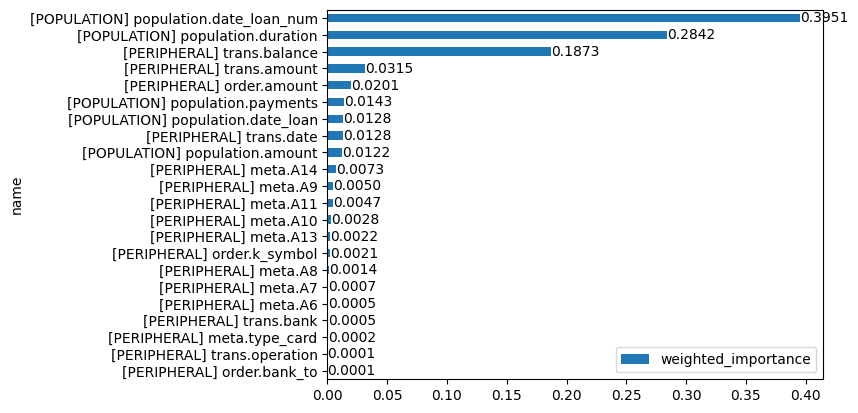

In [17]:
target_weights = (
    container.train.population[container.train.population.roles.target]
    .to_pandas().sum().to_dict()
)

ax = (
    pipe.columns.sort(by="importances").to_pandas()
    .assign(name=lambda df: df.marker.str.cat(df.table, sep=" ")
            .str.cat(df.name, sep="."))
    .pipe(lambda df: df[df.groupby("target")["importance"].transform("sum") > 0])
    .groupby(["name", "target"], as_index=False)["importance"].mean()
    .assign(w=lambda df: df.target.map(target_weights))
    .groupby("name")
    .apply(lambda g: (g.importance * g.w).sum() / g.w.sum(), include_groups=False)
    .rename("weighted_importance")
    .reset_index()
    .pipe(lambda df: df.sort_values("weighted_importance")
          .plot.barh(x="name", y="weighted_importance"))
)

_ = ax.bar_label(ax.containers[0], fmt="%.4f")

---
## Conclusion

In this notebook, we demonstrated how to build a *time-aware, relational* model for customer default prediction using getML. We:
1. Loaded and annotated the data ,
2. Defined a DataModel to represent their relationships,
3. Applied getML's FastProp for automated feature engineering using propositionalization,
4. Trained an XGBoostClassifier,
5. Evaluated performance on validation set,
6. Analyzed column importances for interpretability.

This provides a solid foundation for default prediction. While further tuning and feature engineering can enhance accuracy, this analysis highlights the strength of getML in terms of model performance, ease of use, and interpretability with minimal code.

### Next Steps
To explore model tuning or integrate custom predictors with getML's features, check out [hm-item.ipynb](hm-item.ipynb) in this repository, which focuses on item sales prediction using regression techniques.